<a href="https://colab.research.google.com/github/Nikhil-Nandam/TensorFlow-Notebooks/blob/main/07_Milestone_Project_1_Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: 🍔👁 Food Vision Big™

In the previous notebook ([transfer learning part 3: scaling up](https://github.com/Nikhil-Nandam/TensorFlow-Notebooks/blob/main/06_Transfer_Learning_in_TensorFlow_Part_3_Scaling_Up.ipynb)) we built Food Vision mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) with only 10% of the data.

But you might be wondering, what would happen if we used all the data?

Well, that's what we're going to find out in this notebook!

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** Top-1 accuracy means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). Top-5 accuracy means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

## Check GPU

Google Colab offers free GPUs, however not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, inorder to benfit from mixed precision training, we need access to a Tesla T4 GPU (within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ .

📖 **Resource:** You can read more about the benefits of mixed precision training in the [TensorFlow Mixed Precision documentation](https://www.tensorflow.org/guide/mixed_precision)

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e9e12f59-83d1-448b-5855-8bcb2826dc9f)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The [script](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py) we've got available.

In [2]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-05 10:54:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-05 10:54:21 (72.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the [guide](https://www.tensorflow.org/datasets/overview)

In [4]:
# Get TensorFlow datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders()    # get all available datasets in TFDS
print("food101" in datasets_list)

True


In [6]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,        # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete64V2EW/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete64V2EW/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1)   # samples are in format (image_tensor, label)

In [10]:
# What does one sample of our training data look like
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""Image shape: {image.shape}
Image datatype: {image.dtype}
Target class from Food101 (tensor form): {label}
Class name (str form): {class_names[label.numpy()]}""")

Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class from Food101 (tensor form): 72
Class name (str form): pancakes


In [12]:
# What does our image tensor  from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 42,  40,  51],
        [ 41,  39,  50],
        [ 40,  38,  49],
        ...,
        [ 50,  23,   6],
        [ 51,  24,   7],
        [ 51,  24,   7]],

       [[ 41,  39,  50],
        [ 41,  39,  50],
        [ 41,  39,  50],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 49,  22,   5]],

       [[ 40,  38,  49],
        [ 41,  39,  50],
        [ 42,  40,  51],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 48,  21,   4]],

       ...,

       [[188, 180, 191],
        [188, 180, 191],
        [189, 181, 192],
        ...,
        [179, 178, 186],
        [177, 176, 184],
        [175, 174, 182]],

       [[185, 177, 188],
        [186, 178, 189],
        [187, 179, 190],
        ...,
        [178, 177, 185],
        [176, 175, 183],
        [175, 174, 182]],

       [[179, 171, 182],
        [181, 173, 184],
        [183, 175, 186],
        ...,
        [177, 176, 18

In [13]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

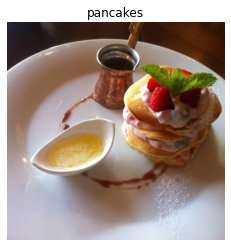

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])   # Add title to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets (TFDS)) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 9 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better 

With these points in mid, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications, we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
1. Reshape our image to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [15]:
# Our data comes in the tuple structure: (image, label)

In [16]:
# Make a function for preprocessing images
def preprocess_image(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes 
    image to [img_shape, img_shape, colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape])  # reshape target image
    # image = image / 255.                                  # scale image values (not required with EfficientNetBX models from tf.keras.applications)
    return tf.cast(image, tf.float32), label                # return (float32_image, label) tuple

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_image(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[42 40 51]
  [41 39 50]
  [40 38 49]
  ...
  [50 23  6]
  [51 24  7]
  [51 24  7]]

 [[41 39 50]
  [41 39 50]
  [41 39 50]
  ...
  [47 20  3]
  [48 21  4]
  [49 22  5]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[41.127552  39.127552  50.127552 ]
  [40.642857  38.642857  49.642857 ]
  [40.285713  38.285713  49.285713 ]
  ...
  [48.92855   21.928549   4.500022 ]
  [47.7398    20.739801   3.7398005]
  [49.301044  22.301043   5.3010426]]

 [[40.642857  38.642857  49.642857 ]
  [42.9949    40.9949    51.9949   ]
  [41.85714   39.85714   50.85714  ]
  ...
  [49.127533  22.127531   4.699003 ]
  [47.862247  20.862246   3.8622463]
  [48.928574  21.928572   4.9285717]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & Prepare Datasets

We're now going to make our data input pipeline run really fast.

Go through the following [guide](https://www.tensorflow.org/guide/data_performance) for more resources on this.

In [19]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow! Map this preprocessing function (`preprocess_image`) across our training dataset, then shuffle a number of elements and the batch them together an finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns in the current batch)"

## Creating modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
- TensorBoard callback to log training results (so we can visualize them later if need be)
- ModelCheckpoint callback to save our model's progress after feature extraction

In [33]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback
from tensorflow.keras.callbacks import ModelCheckpoint

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor="val_accuracy",
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)   # print whether or not model is being saved

## Setup up mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the [TensorFlow guide](https://www.tensorflow.org/guide/mixed_precision) for mixed precision.

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance.

In [34]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")  # set global data policy to mixed precision

In [35]:
!nvidia-smi

Sun Jun  5 12:14:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |   1258MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [37]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Activation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# Create base model
input_shape = (224, 224, 3)
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't, you can have a layer like below
# x = Rescaling(1/255.)(x)

x = base_model(inputs, training=False)     # make sure layers which should be in inference mode only stay like that
x = GlobalAveragePooling2D()(x)
x = Dense(len(class_names))(x)
outputs = Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

## Checking layer dtype policies (are we using mixed precision?)

In [39]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [41]:
# Check the dtype_policy attributes of layers in base model
for number, layer in enumerate(model.layers[1].layers):    # check the layers of the base model (layer at index 1 of `model`)
    print(number, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_3 False float32 <Policy "float32">
1 rescaling_2 False float32 <Policy "mixed_float16">
2 normalization_2 False float32 <Policy "mixed_float16">
3 stem_conv_pad False float32 <Policy "mixed_float16">
4 stem_conv False float32 <Policy "mixed_float16">
5 stem_bn False float32 <Policy "mixed_float16">
6 stem_activation False float32 <Policy "mixed_float16">
7 block1a_dwconv False float32 <Policy "mixed_float16">
8 block1a_bn False float32 <Policy "mixed_float16">
9 block1a_activation False float32 <Policy "mixed_float16">
10 block1a_se_squeeze False float32 <Policy "mixed_float16">
11 block1a_se_reshape False float32 <Policy "mixed_float16">
12 block1a_se_reduce False float32 <Policy "mixed_float16">
13 block1a_se_expand False float32 <Policy "mixed_float16">
14 block1a_se_excite False float32 <Policy "mixed_float16">
15 block1a_project_conv False float32 <Policy "mixed_float16">
16 block1a_project_bn False float32 <Policy "mixed_float16">
17 block2a_expand_conv False float32 <Pol

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple of output layers with base layers frozen)
2. Fine-tune some of the frozen layers


In [42]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220605-121527
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8219 - accuracy: 0.5570
Epoch 1: val_accuracy improved from -inf to 0.67611, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 178s 71ms/step - loss: 1.8219 - accuracy: 0.5570 - val_loss: 1.2276 - val_accuracy: 0.6761
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2927 - accuracy: 0.6668
Epoch 2: val_accuracy improved from 0.67611 to 0.69730, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 169s 71ms/step - loss: 1.2928 - accuracy: 0.6667 - val_loss: 1.1273 - val_accuracy: 0.6973
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1445 - accuracy: 0.7019
Epoch 3: val_accuracy improved from 0.69730 to 0.70975, saving model to model_checkpoints/cp.ckpt
2368/2368 [====================

In [43]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 49s 62ms/step - loss: 1.0859 - accuracy: 0.7082


[1.0859030485153198, 0.7082376480102539]

## Off to you...

We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, your challenge is to complete the [TEMPLATE]() version of this notebook to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're goint to create Food Vision Big!!!

In [45]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision/"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [46]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [47]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 64s 78ms/step - loss: 1.0859 - accuracy: 0.7082


[1.0859029293060303, 0.7082376480102539]

In [49]:
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

In [50]:
# Download the saved model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-06-05 12:34:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  34.6MB/s    in 0.5s    

2022-06-05 12:34:33 (34.6 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [51]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [53]:
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [54]:
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 61s 71ms/step - loss: 1.0881 - accuracy: 0.7065


[1.088128924369812, 0.7064950466156006]

In [55]:
# unfreeze all layers
for layer in loaded_gs_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [56]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss",   # watch the val loss metric
                               patience=3)           # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   save_best_only=True,
                                   monitor="val_loss")

In [58]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Creating learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss",  
                              factor=0.2,   # multiply the learning rate by 0.2 (reduce by 5x)
                              patience=2,
                              verbose=1,    # print out when learning rate goes down 
                              min_lr=1e-7)

In [59]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are not one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [60]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback(dir_name="training_logs", 
                                                                                               experiment_name="efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint,    # save only the best model during training
                                                                   early_stopping,      # stop model after X epochs of no improvements
                                                                   reduce_lr])          # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220605-123946
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9223 - accuracy: 0.7509INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 428s 173ms/step - loss: 0.9223 - accuracy: 0.7509 - val_loss: 0.8048 - val_accuracy: 0.7794 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.8391INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 378s 159ms/step - loss: 0.5778 - accuracy: 0.8391 - val_loss: 0.7766 - val_accuracy: 0.7881 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 338s 142ms/step - loss: 0.3301 - accuracy: 0.9056 - val_loss: 0.9011 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9489
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 349s 146ms/step - loss: 0.1738 - accuracy: 0.9489 - val_loss: 0.9356 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 339s 143ms/step - loss: 0.0353 - accuracy: 0.9919 - val_loss: 1.0319 - val_accuracy: 0.8061 - lr: 2.0000e-05


In [61]:
# Save the model
loaded_gs_model_path = "07_efficientnetb0_fine_tuned_101_classes_mixed_precision/"
loaded_gs_model.save(loaded_gs_model_path)

INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


In [63]:
# Evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data) 
results_loaded_gs_model_fine_tuned

790/790 [==============================] - 50s 63ms/step - loss: 1.0540 - accuracy: 0.7997


[1.054028034210205, 0.7997227907180786]

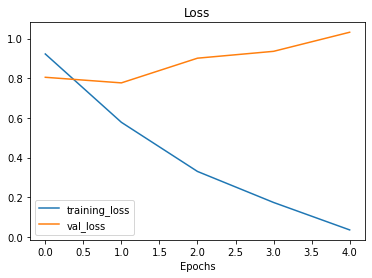

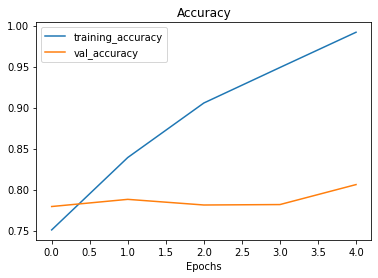

In [62]:
plot_loss_curves(history_101_food_classes_all_data_fine_tune)

In [64]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2022-06-05 13:12:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M  28.8MB/s    in 1.5s    

2022-06-05 13:12:23 (28.8 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



In [65]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [67]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [68]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 53s 65ms/step - loss: 0.9073 - accuracy: 0.8017


[0.907255232334137, 0.8017029762268066]

Excellent! Our saved model is performing as expected (better results than the DeepFood paper!).

Congrautlations! You should be excited! You just trained a computer vision model with competitive performance to a research paper and in far less time (our model took ~20 minutes to train versus DeepFood's quoted 2-3 days).

In other words, you brought Food Vision to life!